In [81]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from torch import utils as t_utils
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
import sys
import os
from torchaudio.utils import download_asset
from helpers import train_loop, test_loop
from IPython.display import Audio
from os import walk
import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import torch.autograd.profiler as profiler
sys.dont_write_bytecode = True
torch.manual_seed(17)
from datetime import datetime


#### Utils

In [38]:
# waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC201443.ogg')
# waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC290158.ogg')

# def record_to_frames(waveform, sample_rate, frame_size=5):
#     p1d = (1, sample_rate * frame_size)
#     out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
#     return out.unfold(1, sample_rate * frame_size, sample_rate * frame_size)

# print(f"{waveform.shape[1] / sample_rate} seconds")
# print(waveform.shape)
# out = record_to_frames(waveform, sample_rate)
# print(f"{out.shape[2] / sample_rate} seconds")

# print(out.shape)
# p1d = (1, sample_rate * 5) # pad last dim by 1 on each side
# out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
# print(waveform.shape[1] / sample_rate)
# print(out.shape)
# print(sample_rate)
# print(out.shape[1] / sample_rate)
# plot_specgram(waveform, sample_rate)
# plot_specgram(out, sample_rate)

## Creating data loader

In [39]:
class_names = sorted(os.listdir('./data/train_audio/'))
class_names_dic = {class_names[i]: i for i in range(0, len(class_names))}
paths = glob.glob("./data/train_audio/**/*.ogg")
print(paths[0].split('\\')[-2])
# df = pd.DataFrame(data={'x': paths, 'y': [x.split('/')[3] for x in paths]})
df = pd.DataFrame(data={'x': paths, 'y': [x.split('\\')[-2] for x in paths]})
# df['y'] = df['y'].map(class_names_dic)
df['y'] = df['y'].astype('category')
# filter_ = ~df['y'].isin(class_names[:10])
class_names = class_names[:10]
# class_names_dic
df = df.query(f'y in {class_names}')
df['y'] = df['y'].map(class_names_dic)

print(df)
df['y'].info()
# print(firstTen)


abethr1
                                           x  y
0    ./data/train_audio\abethr1\XC128013.ogg  0
1    ./data/train_audio\abethr1\XC363501.ogg  0
2    ./data/train_audio\abethr1\XC363502.ogg  0
3    ./data/train_audio\abethr1\XC363503.ogg  0
4    ./data/train_audio\abethr1\XC363504.ogg  0
..                                       ... ..
468  ./data/train_audio\afmdov1\XC472382.ogg  9
469  ./data/train_audio\afmdov1\XC496970.ogg  9
470  ./data/train_audio\afmdov1\XC530750.ogg  9
471  ./data/train_audio\afmdov1\XC603594.ogg  9
472  ./data/train_audio\afmdov1\XC713456.ogg  9

[473 rows x 2 columns]
<class 'pandas.core.series.Series'>
Int64Index: 473 entries, 0 to 472
Series name: y
Non-Null Count  Dtype   
--------------  -----   
473 non-null    category
dtypes: category(1)
memory usage: 14.8 KB


torch.Size([1, 104490])


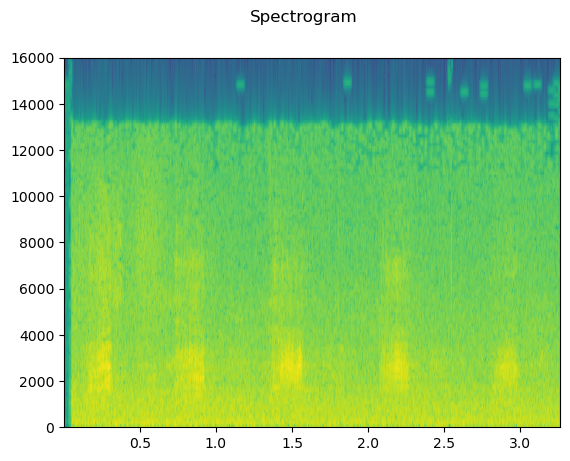

In [40]:
waveform, sample_rate = torchaudio.load('./data/train_audio/yebduc1/XC201443.ogg')
print(waveform.shape)
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    # figure.canvas.draw()
    # data = np.frombuffer(figure.canvas.tostring_rgb(), dtype=np.uint8)
    # data = data.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    # print(data.shape)
    plt.show(block=False)

plot_specgram(waveform, sample_rate)

In [41]:
# waveform.unfold(1, sample_rate * 5, sample_rate * 5).shape

In [42]:
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sample_rate

print(time_axis.shape)
print(num_frames / sample_rate)
print(num_channels, num_frames)
# x.unfold(0, 2, 1)

# plot_specgram(waveform, sample_rate)
# Audio(waveform.numpy(), rate=sample_rate)

torch.Size([104490])
3.2653125
1 104490


In [72]:
import librosa
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

Shape of spectrogram: torch.Size([1, 513, 205])
(513, 205)


<Figure size 640x480 with 0 Axes>

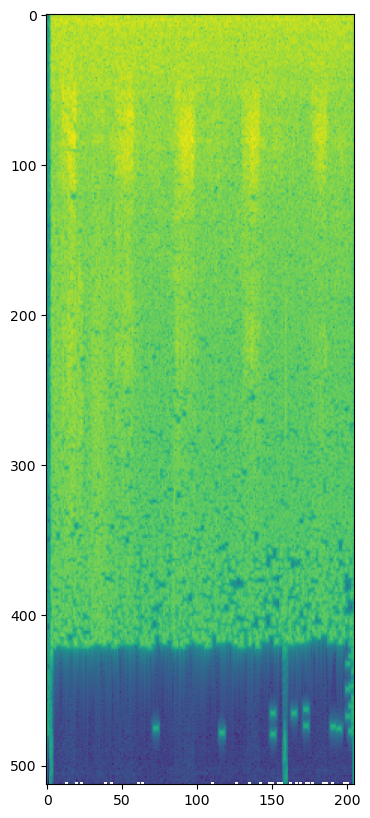

In [43]:

audio_spectogram = torchaudio.transforms.Spectrogram(power=1, n_fft=1024)(waveform)
 
print("Shape of spectrogram: {}".format(audio_spectogram.size()))
plt.figure()
plt.figure(figsize=(10,10))
print(audio_spectogram.log2()[0,:,:].numpy().shape)
plt.imshow(audio_spectogram.log2()[0,:,:].numpy() )

Shape of spectrogram: torch.Size([1, 513, 205])
(513, 205)


<Figure size 640x480 with 0 Axes>

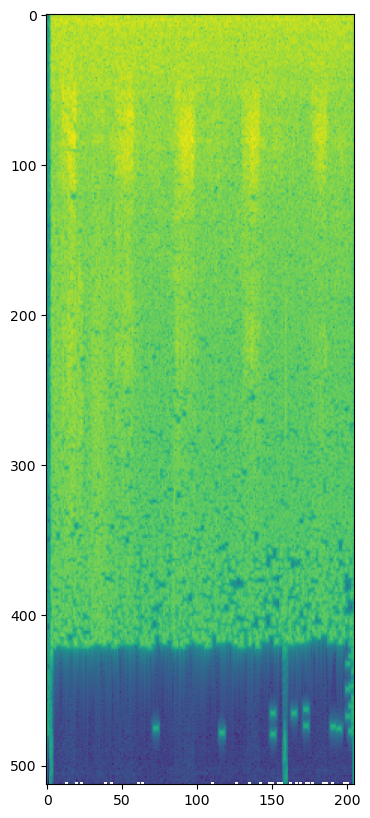

In [66]:
audio_spectogram = torchaudio.transforms.Spectrogram( n_fft=1024, hop_length=512, center=True, pad_mode="reflect", power=2.0 )(waveform)
 
print("Shape of spectrogram: {}".format(audio_spectogram.size()))
plt.figure()
plt.figure(figsize=(10,10))
print(audio_spectogram.log2()[0,:,:].numpy().shape)
plt.imshow(audio_spectogram.log2()[0,:,:].numpy() )

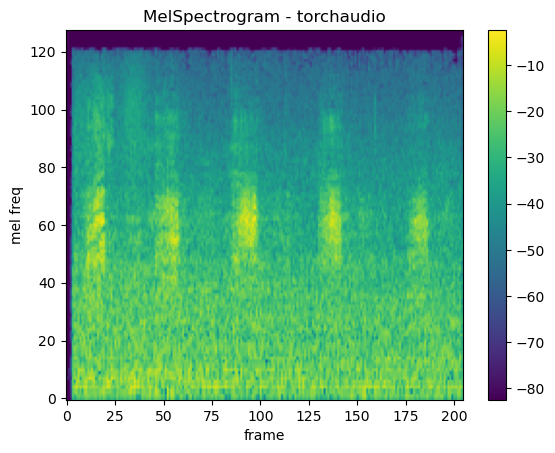

In [74]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
) 
melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [44]:
class TrainAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # self.spectrogram = torchaudio.transforms.Spectrogram( )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]
        label = row['y'] 
        waveform, sample_rate = torchaudio.load(row['x'])
 
        # audio_spectogram = self.spectrogram(waveform)
        # print(sample_rate)
        # return (waveform, sample_rate), label
        return (waveform[0], sample_rate), label

In [45]:
a = TrainAudioDataset(df)

len(a)
 

473

In [55]:

 
# create dataset
dataset = TrainAudioDataset(df)
 
# split dataset
rows = len(dataset) 
test_size = int(rows*0.2)
train_size = rows - test_size
trainDataset, testDataset = random_split(dataset, [train_size, test_size])

# init loaders
batch_size = 32
learning_rate = 1e-3 
epochs = 5

def record_to_frames(waveform, sample_rate, frame_size=5):
    p1d = (1, sample_rate * frame_size)
    out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
    return out.unfold(0, sample_rate * frame_size, sample_rate * frame_size)
spectogram = torchaudio.transforms.Spectrogram(power=1)
def my_collate(batch):
    # print(batch)
    # a, b = batch[0]
    frames = []
    labels = []
    for (data,label) in batch:
            waveform, sample_rate = data
            # print(f"{waveform.shape[0] / sample_rate} seconds")

            l_frames = record_to_frames(torch.tensor(waveform), sample_rate)
            # print(len(l_frames))
            for frame in l_frames:
                audio_spectogram = spectogram(frame)
                audio_spectogram = audio_spectogram.repeat(3, 1, 1) 
                # print(audio_spectogram.size())
                frames.append(audio_spectogram.numpy())
                labels.append(label ) 
        
    
 
    return [frames, labels]
# mainLoader = DataLoader(trainDataset, batch_size=batch_size, collate_fn=my_collate)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, collate_fn=my_collate)
testLoader = DataLoader(testDataset, batch_size=batch_size, collate_fn=my_collate)

In [60]:
 
with profiler.profile(with_stack=True, profile_memory=True) as prof:
    q = iter(trainLoader)
    next(q)
# next(q)
# next(q)

C:\Users\yatsy\AppData\Local\Temp\ipykernel_22096\1838665487.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


In [62]:
# torch.cuda.empty_cache()
# print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=15))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        59.06%     897.894ms       100.00%        1.520s        1.520s     434.83 Mb      -4.38 Mb             1  
                                              aten::abs         8.36%     127.072ms        18.28%     277.915ms     588.803us     144.94 Mb     -17.81 Mb           472  
                                            aten::copy_         6.90%     104.893ms         6.90%     104.893ms     195.696us      -3.69 Mb      -3.69

In [88]:

from torchsummary import summary
torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.BatchNorm2d(3),
            nn.Conv2d(kernel_size=6, stride=3, padding=0, in_channels=3, out_channels=3),
            # nn.Dropout(0.25), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=3), 
            nn.Flatten(),
            # nn.Linear(5544, 5544),
            # nn.ReLU(),
            nn.Linear(5544, len(class_names))
        )

    def forward(self, x: torch.Tensor):
        # x = torch.unsqueeze(x, 0)
        # print('in:', x.size())

        logits = self.linear_relu_stack(x)
        # print('out:', logits.size())

        # print(logits.size())
        return logits
    

model = NeuralNetwork().to(device) 
# print(model)

summary(model, input_size=(3, 201, 801))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 201, 801]               6
            Conv2d-2           [-1, 3, 66, 266]             327
              ReLU-3           [-1, 3, 66, 266]               0
         MaxPool2d-4            [-1, 3, 21, 88]               0
           Flatten-5                 [-1, 5544]               0
            Linear-6                   [-1, 10]          55,450
Total params: 55,783
Trainable params: 55,783
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.84
Forward/backward pass size (MB): 4.57
Params size (MB): 0.21
Estimated Total Size (MB): 6.63
----------------------------------------------------------------


In [89]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if(False):
  checkpoint = torch.load(os.path.join('./m', f'model4.pth'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  # loss_fn = checkpoint['loss']
 

In [90]:
def train_loop(dataloader, model, criteria, optimizer ):
    size = len(dataloader.dataset)
    count = 0
    epochs = 3
    
    
    for i in range(5): 
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), leave=False):
            X = torch.FloatTensor(X).to(device)
            y = torch.as_tensor(y).to(device)
            pred = model(X) 
            loss = criteria(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        
        today = datetime.today().strftime('%Y-%m-%d')
        load_name = os.path.join('./m', f'model{today}{i}.pth')
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criteria, 
            }, load_name)
        
         



train_loop(trainLoader, model, loss_fn, optimizer)

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\yatsy\AppData\Local\Temp\ipykernel_22096\1838665487.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


KeyboardInterrupt: 

In [ ]:
q = iter(trainLoader)
# X, y = next(q)
 
# with torch.no_grad():
#     pred = model(torch.FloatTensor(X ).to(device) )
#     print(torch.argmax(pred ))
#     print(y[0])


In [ ]:
# X, y = next(q)
 
# with torch.no_grad():
#     pred = model(torch.FloatTensor(X ).to(device) )
#     print(torch.argmax(pred ).cpu().numpy())
#     print(y )

In [ ]:
# X, y = next(q)
 
# with torch.no_grad():
#     pred = model(torch.FloatTensor(X).to(device) )
#     print(pred.size())
#     print(pred.argmax(1))
#     print(y)

#     corr = (pred.argmax(1) == torch.FloatTensor(y).to(device)).type(torch.float).sum().item()
#     print(corr)
#     print(len(y))

In [91]:
from statistics import mode

size = 0
num_batches = len(testLoader)
correct = 0
test_loss = 0
with torch.no_grad():
    for (X, y) in testLoader:
        results = np.array([])
        X = torch.FloatTensor(X).cuda()
        # print(X.size()[0])
        # for i in range(len(X)):
        #     frame = torch.FloatTensor(X[i]).to(device)
        #     locY = torch.zeros(1, len(class_names)).to(device)
        #     # locY[0][y[i]] = 1
            
        #     pred = model(frame)
        #     res = torch.argmax(pred[0]).cpu().numpy()
        #     results = np.append(results, res) 
        pred = model(X)
        # print(len(results))
        # print(mode(results))
        # print(len(y))
        # pred = model(X)
        # test_loss += loss_fn(pred, torch.FloatTensor(y).to(device)).item()
        correct += (pred.argmax(1) == torch.FloatTensor(y).cuda()).type(torch.float).sum().item()
        size += X.size()[0]
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# test_loss /= num_batches
# correct /= size
# print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

C:\Users\yatsy\AppData\Local\Temp\ipykernel_22096\1838665487.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_frames = record_to_frames(torch.tensor(waveform), sample_rate)


Test Error: 
 Accuracy: 16.9%, Avg loss: 0.000000 

Test Error: 
 Accuracy: 27.6%, Avg loss: 0.000000 

Test Error: 
 Accuracy: 8.5%, Avg loss: 0.000000 

